In [290]:
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn import preprocessing
from gudhi import RipsComplex
from gudhi import SimplexTree
from gudhi.weighted_rips_complex import WeightedRipsComplex
import gudhi.representations
import pandas as pd 
import numpy as np
import sklearn
import gudhi
import random
import math
import dcor 
import os

In [291]:
#Read TCGA Data Renal, Breast and Colorectal Cancer

In [438]:
def read_files_create_dataframe(path):
    
    pickle_file_directory = '/Users/lebohangmashatola/Documents/phd/expression/' + path + '.pkl'
    
    df = pd.read_pickle(pickle_file_directory)
    
    filepath_biomarkers = '/Users/lebohangmashatola/downloads/tda_paper/mapk.csv' 
    
    biomarkers = pd.read_csv(filepath_biomarkers, index_col=0, sep=';') 
    biomarkers = biomarkers["x"].to_numpy()    
    gene_exprs_matrix = df[np.intersect1d(df.columns, biomarkers)]

    return np.array(gene_exprs_matrix)

In [439]:
R = read_files_create_dataframe('rnaseq_folfox_r')
S = read_files_create_dataframe('rnaseq_folfox_s')

In [440]:
#Construct a distance correlations matrix for each disease and non-disease dataset

In [441]:
def intergene_correlation_measure(DF):
    
    num_genes = DF.shape[1]
    dist = np.zeros((num_genes, num_genes))
    
    for i in range(num_genes):
        for j in range(i+1, num_genes):
            
            dist[i,j] = dcor.distance_correlation(DF[:,i], DF[:,j]) #Distance Correlations 
    
    dist = dist + dist.T + np.eye(num_genes)
    
    return 1 - dist

In [442]:
M_R = intergene_correlation_measure(R)

In [443]:
M_S = intergene_correlation_measure(S)

In [444]:
#Construct persistent diagrams for each disease and non-disease distance correlations matrix

In [445]:
def persistent_diagram(M_train, M_test):
    
    rips_complex_training = RipsComplex(M_train).create_simplex_tree(max_dimension=1)
    rips_complex_training.collapse_edges()
    rips_complex_training.expansion(2)
    rips_complex_training.persistence(persistence_dim_max=True)
    
    rips_complex_testing = RipsComplex(M_test).create_simplex_tree(max_dimension=1)
    rips_complex_testing.collapse_edges()
    rips_complex_testing.expansion(2)
    rips_complex_testing.persistence(persistence_dim_max=True)
        
    gudhi.plot_persistence_diagram(rips_complex_training.persistence(persistence_dim_max=False), legend=True, fontsize=12)
    gudhi.plot_persistence_diagram(rips_complex_testing.persistence(persistence_dim_max=False), legend=True, fontsize=12)

    
#Determine the wasserstein distance between two persistent diagram

    WD = gudhi.representations.metrics.WassersteinDistance(order=1)
    WD.fit([rips_complex_training.persistence_intervals_in_dimension(1)])
    wd_ = WD.transform([rips_complex_testing.persistence_intervals_in_dimension(1)])
        
    print("Wasserstein Distance (Betti-1): " + str(wd_[0][0]))

Wasserstein Distance (Betti-1): 8.668016590623719


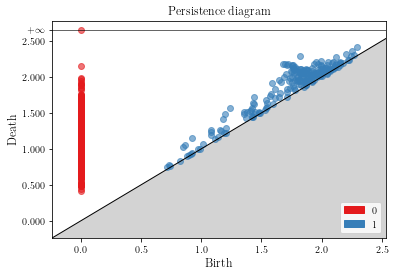

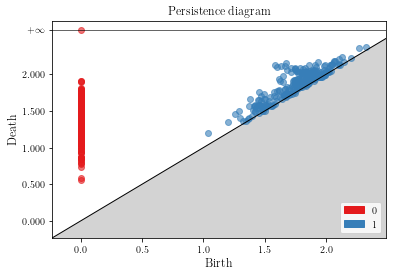

In [446]:
persistent_diagram(M_R, M_S) 